<a href="https://colab.research.google.com/github/paletvoj/01RAD/blob/main/01RAD_Ex04_HW_python_Kohout_Paleta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vojtěch Paleta a Tobiáš Kohout


# 01RAD – Homework Assignment 01 (After Exercise 04)

This homework guides you through data preparation, exploratory analysis, and simple linear regression using a housing market dataset.




## Conditions and grading

- Work on the assignment individually or in Team. If you discuss specific questions with classmates, mention it in the corresponding answer.





## Submission

Submit your work as a Jupyter notebook (`.ipynb`) runnable in Google Colab. Include your name at the top of the notebook. Deadline: **November 2nd  2025**.




## Dataset

Use the CSV file hosted at:

```
https://raw.githubusercontent.com/francji1/01RAD/main/data/sarasota_houses_mod.csv
```

Load the data with `pandas.read_csv`. The table contains 1 057 houses from the Sarasota (FL) area. Columns:

| column | description |
| --- | --- |
| `price` | sale price in USD |
| `living_area` | interior living area in square feet |
| `bathrooms` | number of bathrooms (can be fractional) |
| `bedrooms` | number of bedrooms |
| `fireplaces` | count of fireplaces |
| `lot_size` | lot size in acres |
| `age` | age of the house (years) |
| `fireplace` | boolean indicator whether the house has at least one fireplace |

You will convert the imperial units during the tasks below.




## Data preview



In [1]:
# preview the dataset
import pandas as pd

url = "https://raw.githubusercontent.com/francji1/01RAD/main/data/sarasota_houses_mod.csv"
houses = pd.read_csv(url)
houses.head()


,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
0,142212.0,1982,1.0,3,0,2.00,133,False
1,134865.0,1676,1.5,3,1,0.38,14,True
2,118007.0,1694,2.0,3,1,0.96,15,True
3,138297.0,1800,1.0,2,2,0.48,49,True
4,129470.0,2088,1.0,3,1,1.84,29,True


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.datasets import get_rdataset
from scipy.stats import t,norm

from sklearn.linear_model import LinearRegression


## Task 01 – Data audit

Check whether the dataset contains missing values. If it does, discuss whether you can safely remove the affected observations. Identify which variables are quantitative and which are qualitative (categorical). If a variable could be treated either way, state your choice and rationale. Compute basic descriptive statistics for each variable.



In [3]:
missing = houses[houses.isna().any(axis=1)]

In [4]:
missing

,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
6,50709.0,960,1.5,2,0,NaN,12,False
128,101997.0,1214,1.5,2,0,NaN,17,False
251,282373.0,2793,2.5,3,1,NaN,21,True
412,168065.0,1016,2.0,2,0,NaN,41,False
426,247639.0,1016,2.0,2,0,NaN,41,False
477,97476.0,1219,1.5,2,0,NaN,19,False
501,99311.0,1281,2.5,2,1,NaN,18,True
613,NaN,2960,2.5,4,1,0.61,8,True
737,NaN,1675,2.5,2,1,0.04,18,True
740,247839.0,1536,1.5,3,1,NaN,66,True


Počet záznamů obsahujících chybějící údaj je vzhledem k celkovému počtu pozorování zanedbatelný, a tudíž by smazání neúplných záznamů nemělo mít zásadní vliv na výsledky analýz.

qualitative: fireplace, other variables are quantitative (maybe bathrooms, bedrooms, fireplaces could be treated as qualitative)

In [5]:

### Suggested exchange rates and unit conversions

# with an exchange rate of **1 USD = 23 CZK** and express the price in thousands of CZK.

# Convert areas to square metres:
#  - `living_area` (square feet) → multiply by **0.092903**.
#  - `lot_size` (acres) → multiply by **4046.86**.

houses = houses.dropna()

houses['price'] = 23*houses['price']
houses['living_area'] = 0.092903*houses['living_area']
houses['lot_size'] = 4046.86*houses['lot_size']

houses.head()


,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
0,3270876.0,184.133746,1.0,3,0,8093.7200,133,False
1,3101895.0,155.705428,1.5,3,1,1537.8068,14,True
2,2714161.0,157.377682,2.0,3,1,3884.9856,15,True
3,3180831.0,167.225400,1.0,2,2,1942.4928,49,True
4,2977810.0,193.981464,1.0,3,1,7446.2224,29,True


In [6]:
houses.describe()

,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age
count,1.046000e+03,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,3.857169e+06,169.217130,1.927342,3.191205,0.625239,2308.799401,28.134799
std,1.772414e+06,61.534845,0.651812,0.737096,0.550853,3103.348598,35.061886
min,3.877340e+05,62.430816,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.588512e+06,124.861632,1.500000,3.000000,0.000000,849.840600,6.000000
50%,3.496713e+06,155.984137,2.000000,3.000000,1.000000,1578.275400,18.000000
75%,4.748666e+06,206.430466,2.500000,4.000000,1.000000,2458.467450,34.000000
max,1.379312e+07,485.696884,4.500000,5.000000,4.000000,36421.740000,247.000000



## Task 02 – Unit conversion and filtering

Create a cleaned subset of the data that satisfies all of the following:

1. Convert `price` to thousands of CZK using the exchange rate given above.
2. Convert `living_area` and `lot_size` to square metres.
3. Keep only houses that are older than 10 years but not older than 50 years.
4. Keep only houses with price below 7 500 CZK (in thousands), and lot size between 500 m² and 5 000 m².
5. Convert `bathrooms` and `bedrooms` to categorical variables with three levels of your choice (justify the cut points in your report).

Use this filtered dataset for the remaining tasks unless explicitly noted otherwise, and focus on these variables: `price_czk`, `living_area_m2`, `lot_size_m2`, `bedrooms_cat`, `bathrooms_cat`, `age`, `fireplace`.



In [7]:
cleared_houses = houses[houses["age"] <= 50]
cleared_houses = cleared_houses[cleared_houses["age"] > 10]

cleared_houses = cleared_houses[cleared_houses["price"] < 7_500e3]
cleared_houses = cleared_houses[cleared_houses["lot_size"] < 5_000]
cleared_houses = cleared_houses[cleared_houses["lot_size"] > 500]

Chtěli jsme nemovitosti rozdělit dle velikosti, o nemovitostech s 1 koupelnou očekáváme, že budou velice malé (garsonky) o nemovitostech s <1,5, 2> očekáváme, že budou mít střední velikost a o nemovitostech s >2 koupelnami očekáváme že budou největší.

,bathrooms,bathrooms_cat
1,1.5,1.5 or 2 bathrooms
2,2.0,1.5 or 2 bathrooms
3,1.0,single-bathroom
9,1.5,1.5 or 2 bathrooms
12,1.5,1.5 or 2 bathrooms


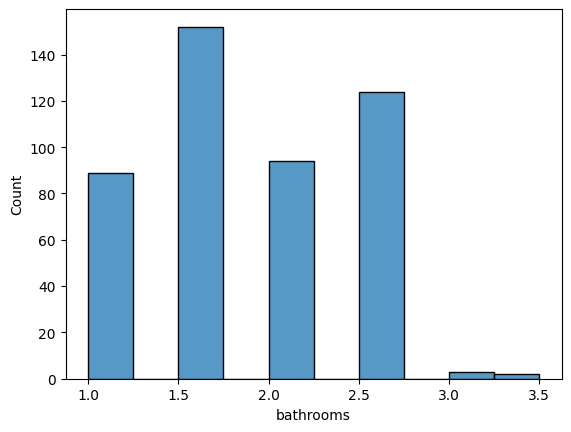

In [8]:
sns.histplot(cleared_houses['bathrooms'])
custom_bins = [cleared_houses['bathrooms'].min()-0.1, 1.1, 2.1, cleared_houses['bathrooms'].max()+0.1]
labels = ['single-bathroom', '1.5 or 2 bathrooms', 'more than two bathrooms']
cleared_houses['bathrooms_cat'] = pd.cut(cleared_houses['bathrooms'], bins=custom_bins, labels=labels)
cleared_houses[['bathrooms', 'bathrooms_cat']].head()

Šlo nám o to, aby se skupiny daly nějak rozumně pojmenovat, rozumně dělily dataset a pak o nich udělat nějaké závěry.

,bedrooms,bedrooms_cat
1,3,three bedrooms
2,3,three bedrooms
3,2,max two bedrooms
9,3,three bedrooms
12,3,three bedrooms


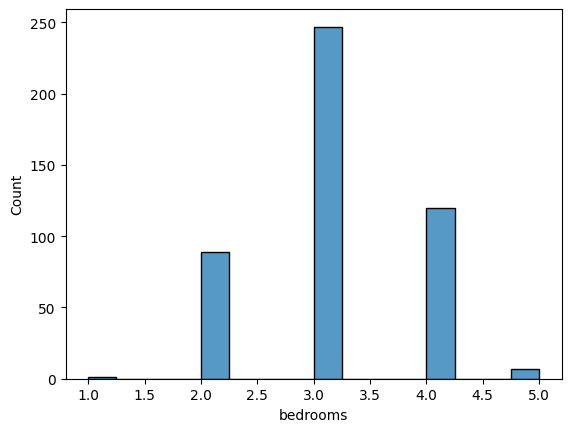

In [9]:
sns.histplot(cleared_houses['bedrooms'])
bins = [cleared_houses['bedrooms'].min()-0.1, 2.1, 3.1, cleared_houses['bedrooms'].max()+0.1]
labels = ['max two bedrooms', 'three bedrooms', 'more than three bedrooms']
cleared_houses['bedrooms_cat'] = pd.cut(cleared_houses['bedrooms'], bins=bins, labels=labels)
cleared_houses[['bedrooms', 'bedrooms_cat']].head()


## Task 03 – Price comparison (fireplace vs no fireplace)

Compare the mean price of houses with a fireplace to those without one. Test the hypothesis that houses with a fireplace have a higher mean price at the 1% significance level. Clearly state the hypotheses, the test statistic you use, its value, and your conclusion.



In [10]:
houses_with_fireplace = cleared_houses[cleared_houses['fireplace']==True]
houses_without_fireplace = cleared_houses[cleared_houses['fireplace']==False]

mean_with = houses_with_fireplace['price'].mean()
mean_without = houses_without_fireplace['price'].mean()

print(f'Průměrná cena domu s krbem: {mean_with:.0f} Kč.')
print(f'Průměrná cena domu bez krbu: {mean_without:.0f} Kč.')

Průměrná cena domu s krbem: 3757021 Kč.
Průměrná cena domu bez krbu: 2796872 Kč.


In [11]:
#normalita -> homogenita rozptylů (F-test) -> t-test

#visual normality check below (density plot of price CZK)

print('F-test:')
#H_0: houses_with_fireplace['price'].var() = houses_without_fireplace['price'].var()
#H_1: houses_with_fireplace['price'].var() != houses_without_fireplace['price'].var()

alpha = 0.01

s_with_squared = houses_with_fireplace['price'].var()
s_without_squared = houses_without_fireplace['price'].var()
F_stat = s_with_squared/s_without_squared
df1 = len(houses_with_fireplace['price']) - 1
df2 = len(houses_without_fireplace['price']) - 1
F_crit = stats.f.ppf(1-alpha/2, df1, df2)
print(f'F-statistika: {F_stat:.4f}')
print(f'F-kritická hodnota: {F_crit:.4f}')
p_val = 2*(1 - stats.f.cdf(F_stat, df1, df2))
print(f'p-hodnota F-testu homogenity rozptylů: {p_val:.4f}')
if p_val < alpha:
    print(f'p-hodnota je menší než {alpha}, zamítáme H_0')
else:
    print(f'p-hodnota je větší než {alpha}, nezamítáme H_0')

print('-------------------------------')

print('t-test')
#H_0: houses_with_fireplace['price'].mean() = houses_without_fireplace['price'].mean()
#H_1: houses_with_fireplace['price'].mean() > houses_without_fireplace['price'].mean()
t_stat, p_value= stats.ttest_ind(houses_with_fireplace['price'], houses_without_fireplace['price'], equal_var = False, alternative= 'greater')
print(f't-statistika: {t_stat:.4f}')
nu = (s_with_squared/len(houses_with_fireplace)+s_without_squared/len(houses_without_fireplace))**2/((1/df1)*(s_with_squared/len(houses_with_fireplace))**2 + (1/df2)*(s_without_squared/len(houses_without_fireplace))**2)
t_crit = stats.t.ppf(1-alpha/2, nu)
print(f't-kritická hodnota: {t_crit:.4f}')
print(f'p-hodnota: {p_value}')
if p_value < alpha:
    print(f'p-hodnota je menší než {alpha}, zamítáme H_0')
else:
    print(f'p-hodnota je větší než {alpha}, nezamítáme H_0')

F-test:
F-statistika: 1.4866
F-kritická hodnota: 1.4168
p-hodnota F-testu homogenity rozptylů: 0.0034
p-hodnota je menší než 0.01, zamítáme H_0
-------------------------------
t-test
t-statistika: 11.2516
t-kritická hodnota: 2.5867
p-hodnota: 2.1848422647325725e-26
p-hodnota je menší než 0.01, zamítáme H_0



# Data visualisation

## Task 04 – Exploratory plots

- Draw scatter plots for each pair of numerical variables, using colour to indicate the presence of a fireplace (`fireplace`).
- Plot boxplots (or violin plots) of `price_czk` against the categorical versions of `bedrooms`, `bathrooms`, and the boolean `fireplace` indicator.
- Display a histogram of `price_czk` and overlay a kernel density estimate.



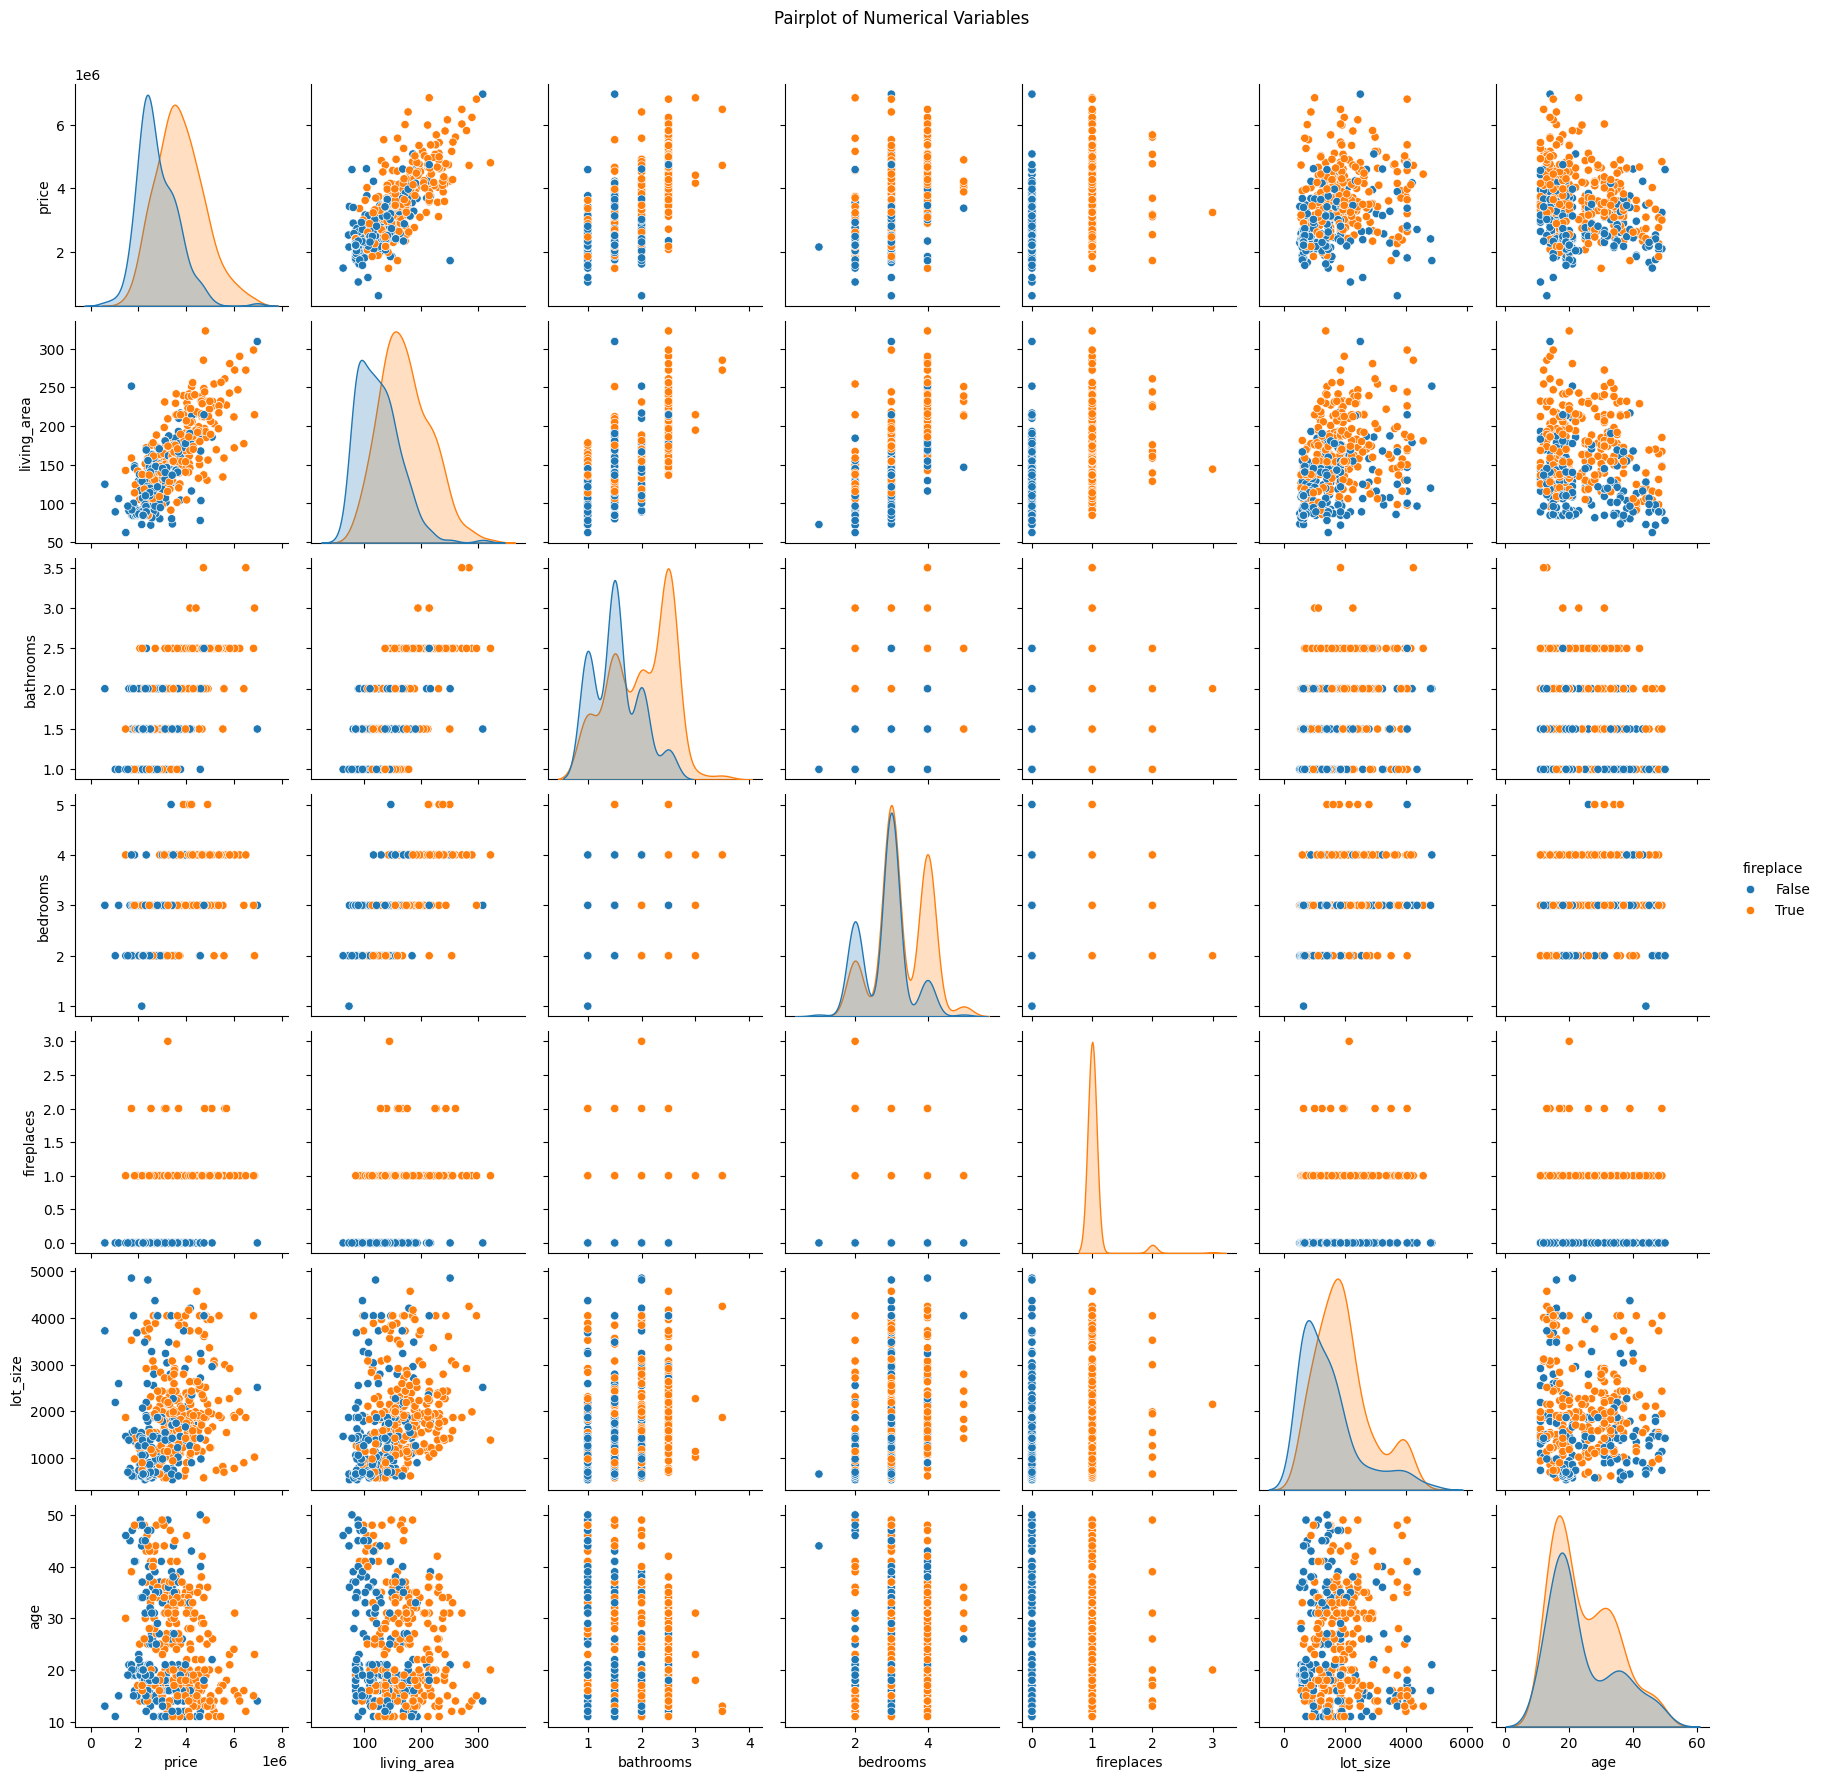

In [12]:
pairplot = sns.pairplot(cleared_houses, hue="fireplace")
pairplot.fig.suptitle("Pairplot of Numerical Variables", y=1.02)
plt.show()

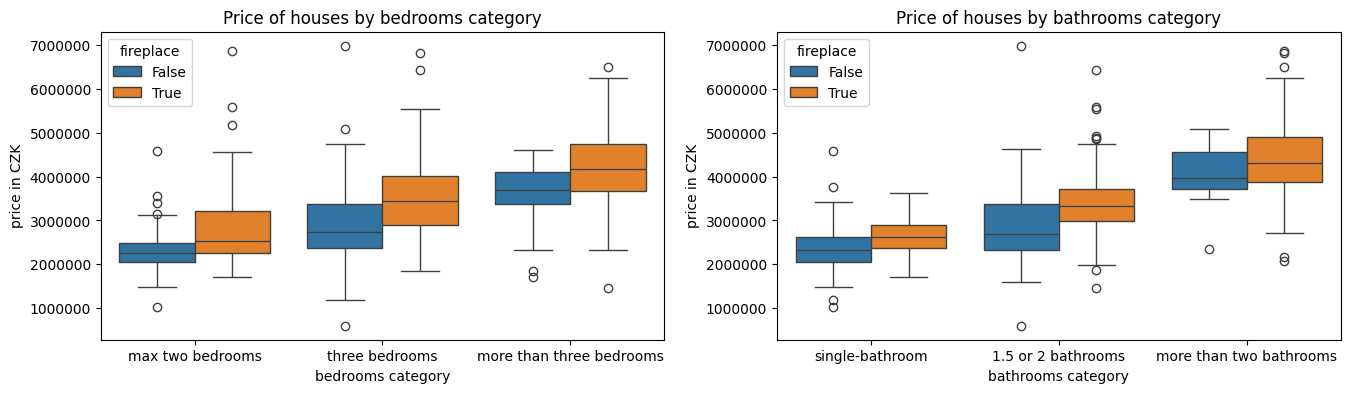

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(data=cleared_houses, x='bedrooms_cat', y='price', hue='fireplace', ax=axes[0])
sns.boxplot(data=cleared_houses, x='bathrooms_cat', y='price', hue='fireplace', ax=axes[1])
axes[0].set_title('Price of houses by bedrooms category')
axes[0].set_xlabel('bedrooms category')
axes[0].set_ylabel('price in CZK')
axes[0].ticklabel_format(style='plain', axis='y')
axes[1].set_title('Price of houses by bathrooms category')
axes[1].set_xlabel('bathrooms category')
axes[1].set_ylabel('price in CZK')
axes[1].ticklabel_format(style='plain', axis='y')

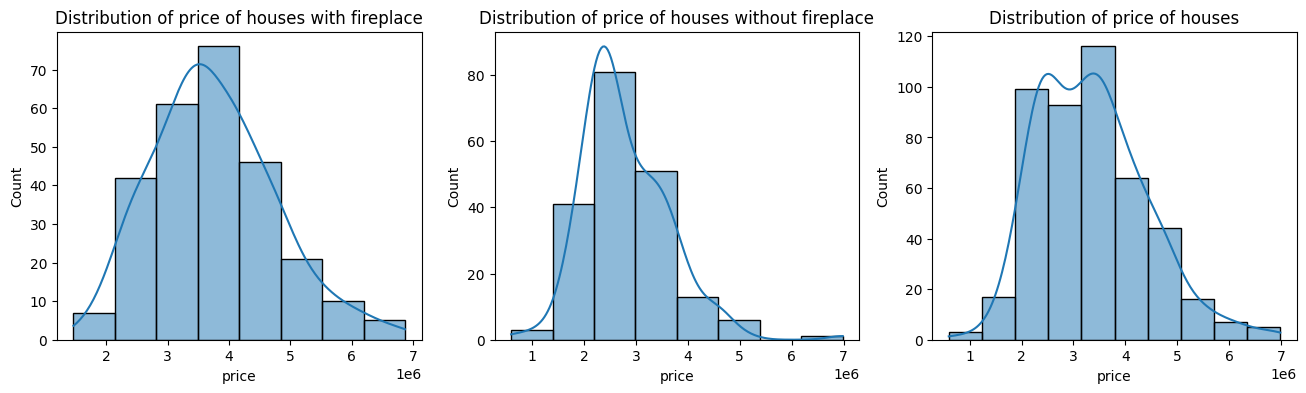

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('Distribution of price of houses with fireplace')
sns.histplot(houses_with_fireplace["price"], bins=8, kde=True, ax=axes[0])
axes[1].set_title('Distribution of price of houses without fireplace')
sns.histplot(houses_without_fireplace["price"], bins=8, kde=True, ax=axes[1])
axes[2].set_title('Distribution of price of houses')
sns.histplot(cleared_houses["price"], bins=10, kde=True, ax=axes[2])
plt.show()

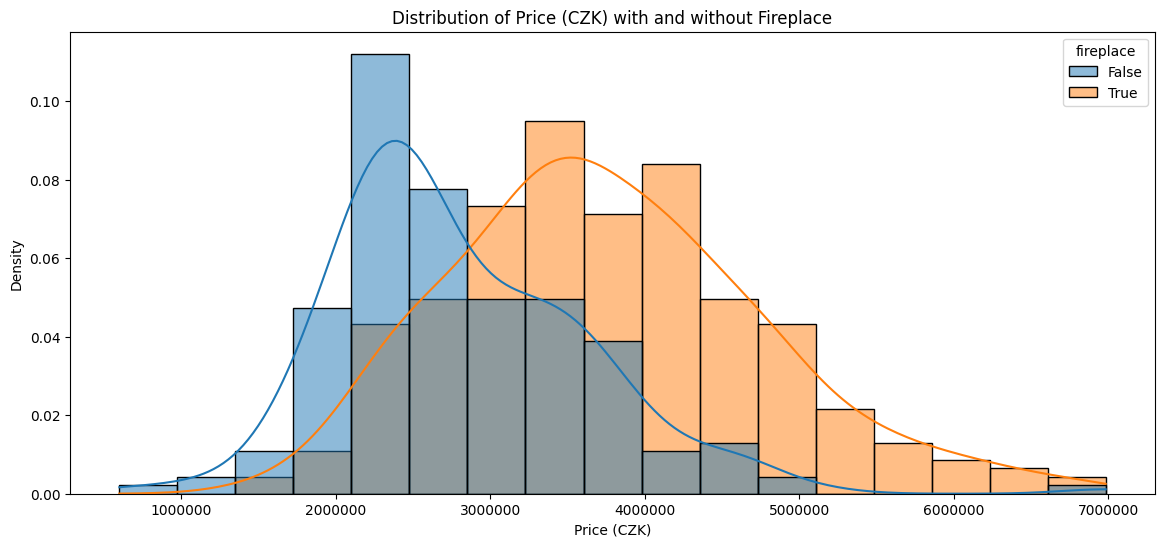

In [15]:
plt.figure(figsize=(14, 6))
sns.histplot(data=cleared_houses, x='price', hue='fireplace', kde=True, stat='probability')
plt.title('Distribution of Price (CZK) with and without Fireplace')
plt.xlabel('Price (CZK)')
plt.ylabel('Density')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


## Task 05 – Combined categories

For the combinations of `bedrooms_cat` and `bathrooms_cat`, visualise the distribution of `price_czk`. Ensure that the plot clearly shows which combinations exist in the filtered dataset and whether price levels differ across them.



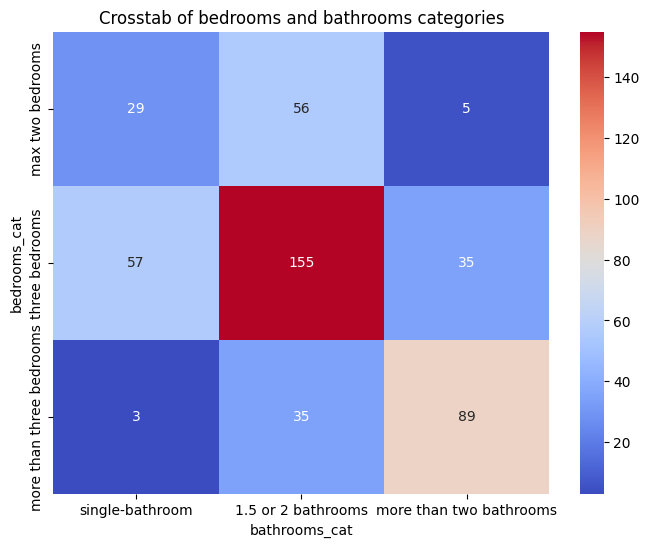

In [16]:
plt.figure(figsize=(8, 6))
matrix = pd.crosstab(cleared_houses['bedrooms_cat'], cleared_houses['bathrooms_cat'])
sns.heatmap(matrix, annot=True, fmt="d", cmap='coolwarm')
plt.title('Crosstab of bedrooms and bathrooms categories')
plt.show()

In [17]:
# Count observations for each combined category
cleared_houses['bedroom_bathroom_cat'] = cleared_houses['bedrooms_cat'].astype(str) + ' & ' + cleared_houses['bathrooms_cat'].astype(str)
combined_category_counts = cleared_houses['bedroom_bathroom_cat'].value_counts()
combined_category_counts.columns = ['Bedroom & Bathroom Category', 'Count']
display(combined_category_counts)

,count
bedroom_bathroom_cat,
three bedrooms & 1.5 or 2 bathrooms,155
more than three bedrooms & more than two bathrooms,89
three bedrooms & single-bathroom,57
max two bedrooms & 1.5 or 2 bathrooms,56
more than three bedrooms & 1.5 or 2 bathrooms,35
three bedrooms & more than two bathrooms,35
max two bedrooms & single-bathroom,29
max two bedrooms & more than two bathrooms,5
more than three bedrooms & single-bathroom,3


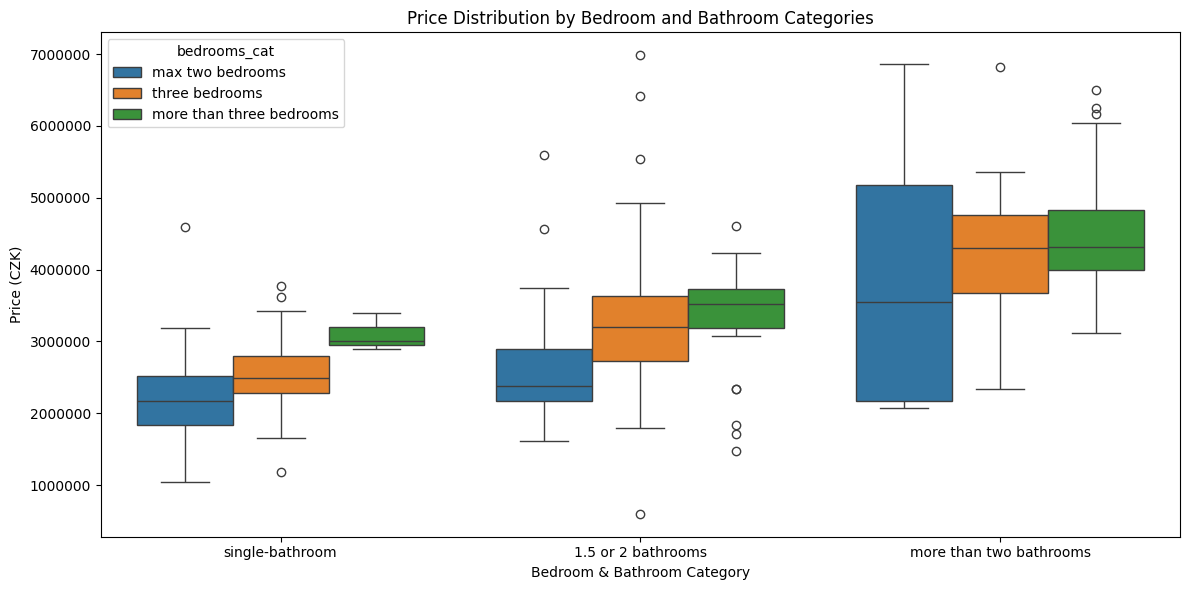

In [18]:
# Visualize the distribution of price_czk for combined categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleared_houses, x='bathrooms_cat', y='price', hue = 'bedrooms_cat')
plt.title('Price Distribution by Bedroom and Bathroom Categories')
plt.xlabel('Bedroom & Bathroom Category')
plt.ylabel('Price (CZK)')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


## Task 06 – Focus on two-bedroom houses

Restrict the data to houses with exactly two bedrooms (before categorisation). Plot `price_czk` against `living_area_m2`, colour the points by `fireplace`, and scale the point size according to the number of bathrooms (treat `bathrooms` as numeric for this plot).




**From this point on, continue working with the subset of two-bedroom houses unless a task specifies otherwise.**



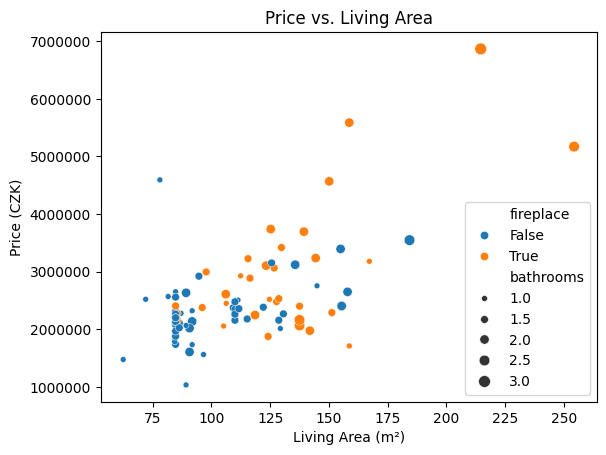

In [19]:
cleared_houses = cleared_houses.drop('bathrooms_cat', axis=1)
cleared_houses = cleared_houses.drop('bedrooms_cat', axis=1)
cleared_houses = cleared_houses[cleared_houses['bedrooms']==2]
sns.scatterplot(data=cleared_houses, x='living_area', y='price', hue='fireplace', size='bathrooms')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Price vs. Living Area')
plt.xlabel('Living Area (m²)')
plt.ylabel('Price (CZK)')
plt.show()


# Simple linear regression




## Task 07 – Simple regression (with and without intercept)

Fit two linear models explaining `price_czk` by `living_area_m2`: one with an intercept and one without. Report $R^2$ and the $F$-statistic for both models. Choose the model you prefer and justify your choice. Using the selected model, answer whether price depends on living area and by how much the expected price changes if the living area increases by 20 m².



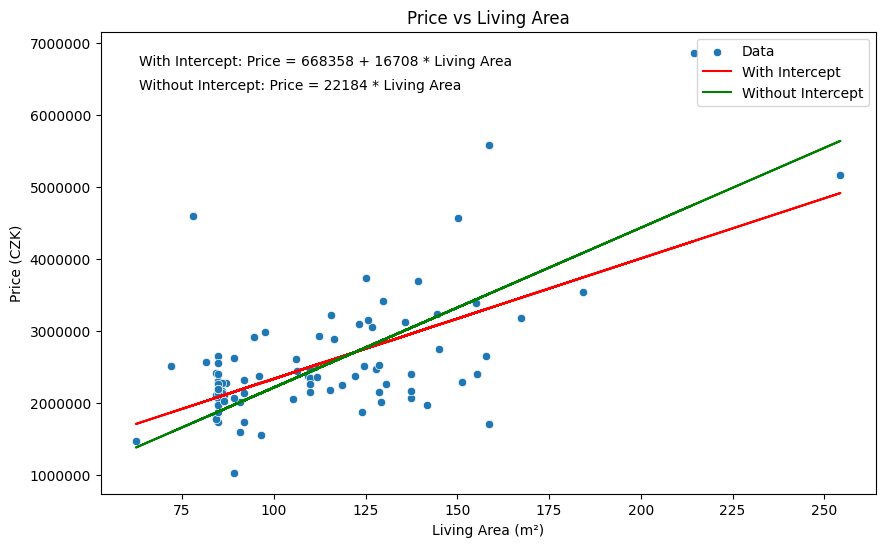

R^2 with intercept: 0.3837
R^2 without intercept: 0.9319
F-statistic with intercept: 54.1713
F-statistic without intercept: 1203.9025
For model without intercept: If living area increases by 20 m^2, expected price changes by: 443685 Kč


In [20]:
with_intercept = smf.ols(formula='price ~ living_area', data=cleared_houses).fit()
without_intercept = smf.ols(formula='price ~ living_area + 0', data=cleared_houses).fit()
#print(with_intercept.summary())
#print(without_intercept.summary())
R2_with = with_intercept.rsquared
R2_without = without_intercept.rsquared
F_with = with_intercept.fvalue
F_without = without_intercept.fvalue

#s_n_with = with_intercept.mse_resid
#s_n_without = without_intercept.mse_resid
#print(f's^2 with intercept: {s_n_with:.0f}')
#print(f's^2 without intercept: {s_n_without:.0f}')

# Plotting the regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleared_houses, x='living_area', y='price', label='Data')

# Plot regression line with intercept
plt.plot(cleared_houses['living_area'], with_intercept.predict(cleared_houses['living_area']), color='red', label='With Intercept')

# Plot regression line without intercept
plt.plot(cleared_houses['living_area'], without_intercept.predict(cleared_houses['living_area']), color='green', label='Without Intercept')

# Add regression formulas to the plot
plt.text(0.05, 0.95, f'With Intercept: Price = {with_intercept.params["Intercept"]:.0f} + {with_intercept.params["living_area"]:.0f} * Living Area', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f'Without Intercept: Price = {without_intercept.params["living_area"]:.0f} * Living Area', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')


plt.title('Price vs Living Area')
plt.xlabel('Living Area (m²)')
plt.ylabel('Price (CZK)')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

print(f'R^2 with intercept: {R2_with:.4f}')
print(f'R^2 without intercept: {R2_without:.4f}')
print(f'F-statistic with intercept: {F_with:.4f}')
print(f'F-statistic without intercept: {F_without:.4f}')


price_change = 20 * without_intercept.params['living_area']
print(f'For model without intercept: If living area increases by 20 m^2, expected price changes by: {price_change:.0f} Kč')

Vybrali jsme si model **bez interceptu**, neboť cena realit je často uváděna v přepočtu na metry čtvereční, a tak bychom očekávali přímou úměru mezi cenou a plochou.


## Task 08 – Separate models by fireplace

Fit the same simple regression separately for houses with a fireplace and without a fireplace. Which group exhibits a stronger linear relationship between price and living area? By how much does the slope differ between the two models? Compute 95% confidence intervals for the slopes and discuss whether they overlap. Estimate the percentage difference in expected price for a 160 m² house with a fireplace versus one without a fireplace.



In [21]:
houses_with_fireplace = cleared_houses[cleared_houses['fireplace']==True]
houses_without_fireplace = cleared_houses[cleared_houses['fireplace']==False]

# Fit models with intercept
model_with_fireplace = smf.ols(formula='price ~ living_area', data=houses_with_fireplace).fit()
model_without_fireplace = smf.ols(formula='price ~ living_area', data=houses_without_fireplace).fit()

# Report R^2 and compare
R2_fire = model_with_fireplace.rsquared
R2_no_fire = model_without_fireplace.rsquared

print(f'R^2 for houses with fireplace: {R2_fire:.4f}')
print(f'R^2 for houses without fireplace: {R2_no_fire:.4f}')

if R2_fire > R2_no_fire:
    print('Houses with a fireplace exhibit a stronger linear relationship.')
else:
    print('Houses without a fireplace exhibit a stronger linear relationship.')

# Calculate and report the difference in slopes
slope_fire = model_with_fireplace.params['living_area']
slope_no_fire = model_without_fireplace.params['living_area']
slope_difference = slope_fire - slope_no_fire

print(f'\nSlope for houses with fireplace: {slope_fire:.0f}')
print(f'Slope for houses without fireplace: {slope_no_fire:.0f}')
print(f'Difference in slopes: {slope_difference:.0f}')

# Compute and discuss 95% confidence intervals for the slopes
conf_int_fire = model_with_fireplace.conf_int(alpha=0.05).loc['living_area']
conf_int_no_fire = model_without_fireplace.conf_int(alpha=0.05).loc['living_area']

print(f'\n95% Confidence Interval for slope (with fireplace): [{conf_int_fire[0]:.0f}, {conf_int_fire[1]:.0f}]')
print(f'95% Confidence Interval for slope (without fireplace): [{conf_int_no_fire[0]:.0f}, {conf_int_no_fire[1]:.0f}]')

# Check for overlap
overlap = not (conf_int_fire[0] > conf_int_no_fire[1] or conf_int_fire[1] < conf_int_no_fire[0])

if overlap:
    print("The 95% confidence intervals for the slopes overlap.")
else:
    print("The 95% confidence intervals for the slopes do not overlap.")

# Estimate percentage difference in expected price for a 160 m² house
area = 160
expected_price_fire = model_with_fireplace.predict({'living_area': area})[0]
expected_price_no_fire = model_without_fireplace.predict({'living_area': area})[0]

percentage_difference = ((expected_price_fire - expected_price_no_fire) / expected_price_no_fire) * 100

print(f'\nEstimated price for 160 m² house with fireplace: {expected_price_fire:.0f} Kč')
print(f'Estimated price for 160 m² house without fireplace: {expected_price_no_fire:.0f} Kč')
print(f'Percentage difference in expected price: {percentage_difference:.2f}%')

R^2 for houses with fireplace: 0.4346
R^2 for houses without fireplace: 0.1621
Houses with a fireplace exhibit a stronger linear relationship.

Slope for houses with fireplace: 21334
Slope for houses without fireplace: 8559
Difference in slopes: 12775

95% Confidence Interval for slope (with fireplace): [12572, 30096]
95% Confidence Interval for slope (without fireplace): [3199, 13920]
The 95% confidence intervals for the slopes overlap.

Estimated price for 160 m² house with fireplace: 3594407 Kč
Estimated price for 160 m² house without fireplace: 2801596 Kč
Percentage difference in expected price: 28.30%


In [22]:
# Fit models without intercept
model_with_fireplace_no_intercept = smf.ols(formula='price ~ living_area + 0', data=houses_with_fireplace).fit()
model_without_fireplace_no_intercept = smf.ols(formula='price ~ living_area + 0', data=houses_without_fireplace).fit()

# Report R^2 and compare
R2_fire_no_intercept = model_with_fireplace_no_intercept.rsquared
R2_no_fire_no_intercept = model_without_fireplace_no_intercept.rsquared

print(f'R^2 for houses with fireplace (no intercept): {R2_fire_no_intercept:.4f}')
print(f'R^2 for houses without fireplace (no intercept): {R2_no_fire_no_intercept:.4f}')

if R2_fire_no_intercept > R2_no_fire_no_intercept:
    print('Houses with a fireplace exhibit a stronger linear relationship (based on R-squared).')
else:
    print('Houses without a fireplace exhibit a stronger linear relationship (based on R-squared).')


# Calculate and report the difference in slopes
slope_with = model_with_fireplace_no_intercept.params['living_area']
slope_without = model_without_fireplace_no_intercept.params['living_area']
slope_difference = slope_with - slope_without

print(f'\nSlope for houses with fireplace (no intercept): {slope_with:.0f}')
print(f'Slope for houses without fireplace (no intercept): {slope_without:.0f}')
print(f'Difference in slopes (no intercept): {slope_difference:.0f}')

# Compute and discuss 95% confidence intervals for the slopes
conf_int_fire_no_intercept = model_with_fireplace_no_intercept.conf_int(alpha=0.05).loc['living_area']
conf_int_no_fire_no_intercept = model_without_fireplace_no_intercept.conf_int(alpha=0.05).loc['living_area']

print(f'\n95% Confidence Interval for slope (with fireplace, no intercept): [{conf_int_fire_no_intercept[0]:.0f}, {conf_int_fire_no_intercept[1]:.0f}]')
print(f'95% Confidence Interval for slope (without fireplace, no intercept): [{conf_int_no_fire_no_intercept[0]:.0f}, {conf_int_no_fire_no_intercept[1]:.0f}]')

# Check for overlap
overlap = not (conf_int_fire_no_intercept[0] > conf_int_no_fire_no_intercept[1] or conf_int_fire_no_intercept[1] < conf_int_no_fire_no_intercept[0])

if overlap:
    print("The 95% confidence intervals for the slopes overlap (no intercept).")
else:
    print("The 95% confidence intervals for the slopes do not overlap (no intercept).")

# Estimate percentage difference in expected price for a 160 m² house
area = 160
expected_price_with = model_with_fireplace_no_intercept.predict({'living_area': area})[0]
expected_price_without = model_without_fireplace_no_intercept.predict({'living_area': area})[0]

percentage_difference = ((expected_price_with - expected_price_without) / expected_price_without) * 100

print(f'\nEstimated price for 160 m² house with fireplace (no intercept): {expected_price_with:.0f} Kč')
print(f'Estimated price for 160 m² house without fireplace (no intercept): {expected_price_without:.0f} Kč')
print(f'Percentage difference in expected price (no intercept): {percentage_difference:.2f}%')

R^2 for houses with fireplace (no intercept): 0.9299
R^2 for houses without fireplace (no intercept): 0.9348
Houses without a fireplace exhibit a stronger linear relationship (based on R-squared).

Slope for houses with fireplace (no intercept): 22636
Slope for houses without fireplace (no intercept): 21731
Difference in slopes (no intercept): 905

95% Confidence Interval for slope (with fireplace, no intercept): [20435, 24836]
95% Confidence Interval for slope (without fireplace, no intercept): [20166, 23297]
The 95% confidence intervals for the slopes overlap (no intercept).

Estimated price for 160 m² house with fireplace (no intercept): 3621701 Kč
Estimated price for 160 m² house without fireplace (no intercept): 3476980 Kč
Percentage difference in expected price (no intercept): 4.16%



## Task 09 – Visual comparison of models

Create a scatter plot of `living_area_m2` versus `price_czk` showing the two fitted regression lines (with and without a fireplace). Add 90% confidence bands for the mean predictions. Use the plot to comment on whether expected prices differ for houses with living area below 120 m². Explain whether this comparison is appropriate.



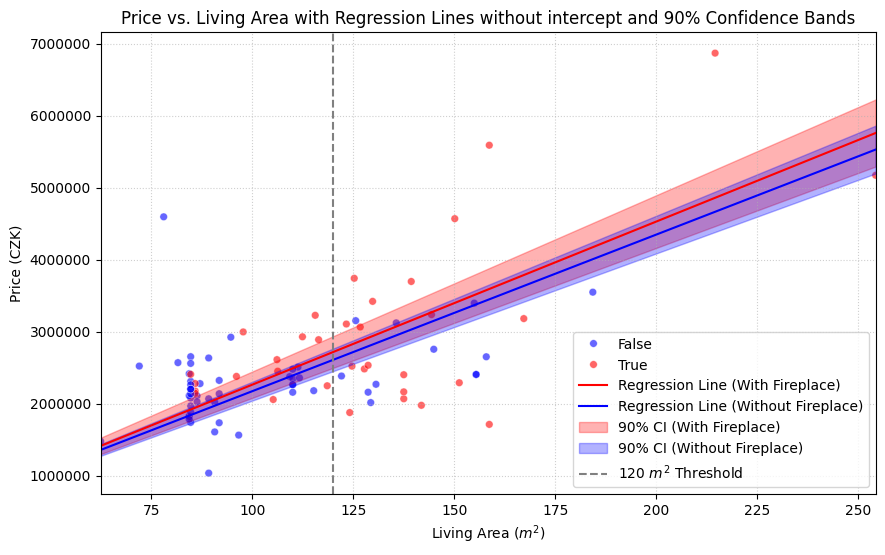

In [23]:
# --- Plotting Section ---
plt.figure(figsize=(10, 6))
# 1. Create a scatter plot of living_area_m2 versus price_czk
sns.scatterplot(
    x='living_area',
    y='price',
    hue='fireplace',
    data=cleared_houses,
    palette=['blue', 'red'],
    alpha=0.6,
    s=30
)

# Create an array of living areas for prediction across the data range
min_area = cleared_houses['living_area'].min()
max_area = cleared_houses['living_area'].max()
pred_x = pd.DataFrame({'living_area': np.linspace(min_area, max_area, 100)})

# 2. Add the two fitted regression lines
# Houses with fireplace
pred_y_fire = model_with_fireplace_no_intercept.predict(pred_x)
plt.plot(pred_x['living_area'], pred_y_fire, color='red', linestyle='-', label='Regression Line (With Fireplace)')

# Houses without fireplace
pred_y_no_fire = model_without_fireplace_no_intercept.predict(pred_x)
plt.plot(pred_x['living_area'], pred_y_no_fire, color='blue', linestyle='-', label='Regression Line (Without Fireplace)')

# 3. Add 90% confidence bands for the mean predictions (using the models' own data ranges for accuracy)
# Confidence Band for houses with fireplace
pred_conf_fire = model_with_fireplace_no_intercept.get_prediction(pred_x).summary_frame(alpha=0.10) # 90% CI
plt.fill_between(
    pred_x['living_area'],
    pred_conf_fire['mean_ci_lower'],
    pred_conf_fire['mean_ci_upper'],
    color='red',
    alpha=0.3,
    label='90% CI (With Fireplace)'
)

# Confidence Band for houses without fireplace
pred_conf_no_fire = model_without_fireplace_no_intercept.get_prediction(pred_x).summary_frame(alpha=0.10) # 90% CI
plt.fill_between(
    pred_x['living_area'],
    pred_conf_no_fire['mean_ci_lower'],
    pred_conf_no_fire['mean_ci_upper'],
    color='blue',
    alpha=0.3,
    label='90% CI (Without Fireplace)'
)

# Enhance the plot
plt.title('Price vs. Living Area with Regression Lines without intercept and 90% Confidence Bands')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Price (CZK)')
plt.xlim(min_area, max_area)
plt.ticklabel_format(style='plain', axis='y') # Avoid scientific notation on y-axis
plt.axvline(x=120, color='gray', linestyle='--', label='120 $m^2$ Threshold') # Add line for comment area
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Pro domy s obytnou plochou menší než 120 metrů čtverečních platí, že očekávané ceny nemovitostí s krbem jsou vyšší než ceny domů bez krbu, avšak 90% konfidenční interval průměrné ceny nemovitostí bez krbu je u domů s obytnou plochou menší než 120 metrů čtverečních téměř celý podmnožinou konfidenčního intervalu pro průměrnou cenu nemovitosti s krbem.

Nárůst ceny u nemovitostí s krbem je očekávaný, neboť vybudování krbu stojí nezanedbantelnou částku a navíc krb může být indikátorem vyšší kvality zařízení nemovistosti -> a tudíž vyšší hodnoty za metr čtvereční. Pro porovnání efektu těchto dvou věcí by však asi bylo lepší použít model s interceptem.


## Task 10 – Residual diagnostics

Plot histograms of the residuals from the models in Task 09. Overlay the density of a normal distribution with mean zero and variance equal to the estimated $\hat{\sigma}^2$ of each model. Comment on the findings and suggest further model improvements. Plot corresponding QQ plots and  discuss them.



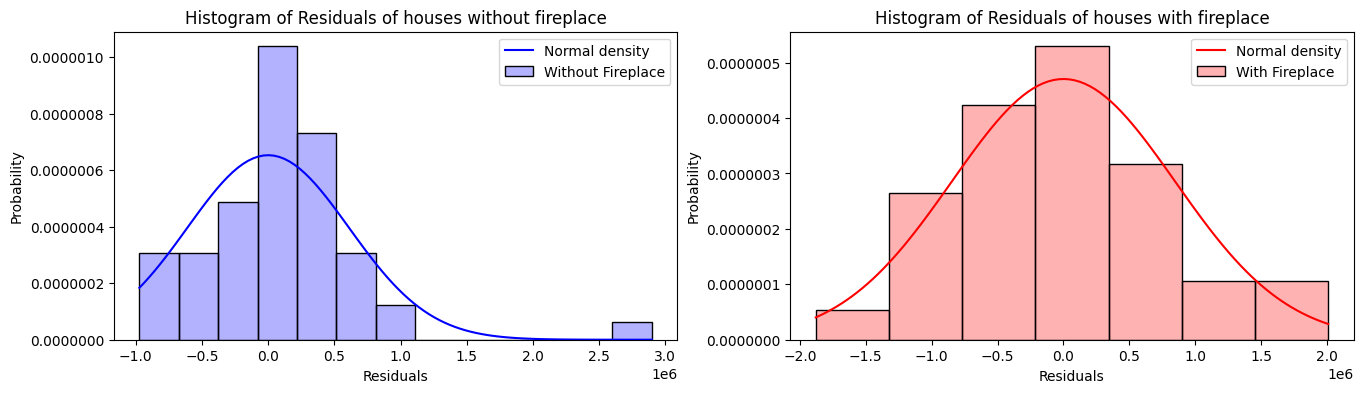

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
residuals_no_fire = model_without_fireplace_no_intercept.resid
residuals_fire = model_with_fireplace_no_intercept.resid
sns.histplot(residuals_no_fire, label='Without Fireplace', stat = 'density',color = 'blue', alpha = 0.3, ax=axes[0])
sns.histplot(residuals_fire, label='With Fireplace', stat = 'density', color = 'red', alpha = 0.3, ax=axes[1])
s_squared_no_fire = model_without_fireplace_no_intercept.mse_resid
s_squared_fire = model_with_fireplace_no_intercept.mse_resid

x_no_fire = np.linspace(residuals_no_fire.min(), residuals_no_fire.max(), 100)

axes[0].plot(x_no_fire, stats.norm.pdf(x_no_fire, loc=0, scale=np.sqrt(s_squared_no_fire)), color = 'blue', label='Normal density')
axes[0].legend()
axes[0].set_title('Histogram of Residuals of houses without fireplace')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Probability')
axes[0].ticklabel_format(style='plain', axis='y')

x_fire = np.linspace(residuals_fire.min(), residuals_fire.max(), 100)
axes[1].plot(x_fire, stats.norm.pdf(x_fire, loc=0, scale=np.sqrt(s_squared_fire)), color = 'red', label='Normal density')
axes[1].legend()
axes[1].set_title('Histogram of Residuals of houses with fireplace')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Probability')
axes[1].ticklabel_format(style='plain', axis='y')

Zatímco rezidua u domů s krbem vykazují normalitu, rezidua u domů bez krbu nekopírují gaussovskou hustotu tak přesně. Již na předchozím obrázku jsme si mohli všimnout, že značná část pozorování se nachází nad regresní přímkou, což potvrzuje i vykreslený histogram.

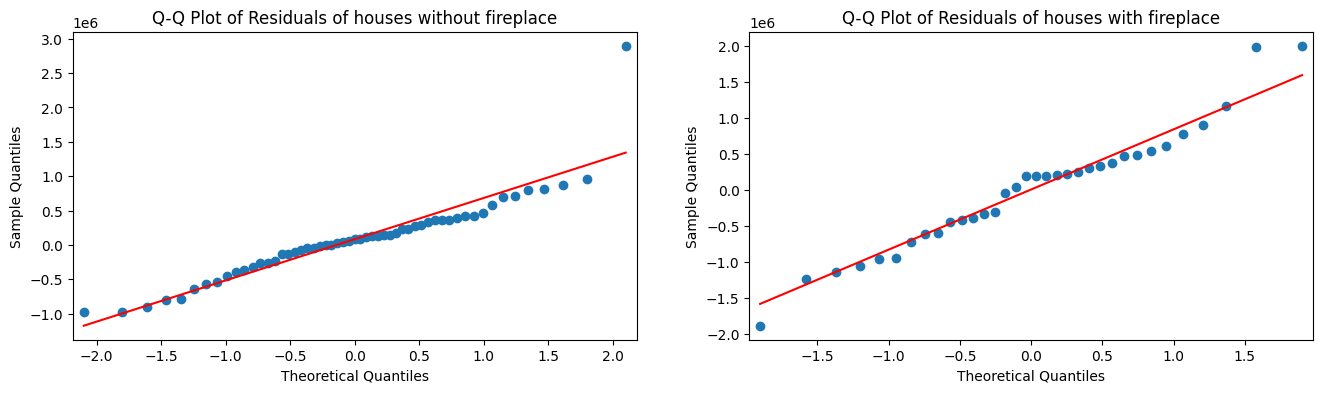

In [25]:
# q-q plots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sm.qqplot(residuals_no_fire, line='s', ax=axes[0])
sm.qqplot(residuals_fire, line='s', ax=axes[1])
axes[0].set_title('Q-Q Plot of Residuals of houses without fireplace')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')
axes[1].set_title('Q-Q Plot of Residuals of houses with fireplace')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
plt.show()

Na prvním q-q plotu si můžeme všimnout odlehlého pozorování a rovněž toho, že body neleží na přímce. Vzhledem k zachycenému trendu je možné, že data mají bimodální rozdělení. Ani na druhém q-q plotu body nekopírují přesně přímku, ale vzhledem k nízkému počtu pozorování si netroufáme normalitu zamítnout.

Celkově jsme v naší analyze zjistili, že hodnota reality je zřejmě závislá na její velikosti v metrech čtvereční. Dále jsme ukázali, že průměrná cena nemovitostí s krbem je vyšší, než těch bez krbu. Pro naši analýzu jsme zvolili model bez interceptu, protože dle našeho vyhodnocení je přímá úměra mezi velikostí a cenou opodstatněná.

Model by šlo dále vylepšit. Prostor k vylepšení nabízí zejména vícerozměrná regrese, neboť jsme pro model použili pouze dvě hodnoty z dataframu (plochu a existenci krbu). Sloupce: `bathrooms	bedrooms	fireplaces	lot_size	age` zůstaly nevyužité. Dalším nápadem na vylepšení jsou například transformace na těchto datech, nebo pokud by bylo dostatek dat, tak použití metod z machine learningu.